In [ ]:
import torch
import torchvision.models as models
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import utils

In [2]:
vgg = models.vgg16(weights="DEFAULT")
vgg.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
with open('imagenet-simple-labels.json', 'r') as f:
    class_names = json.load(f)


pretransform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = transforms.Normalize(mean=mean, std=std) 

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Predicted class: sea snake
Probability: 0.4808


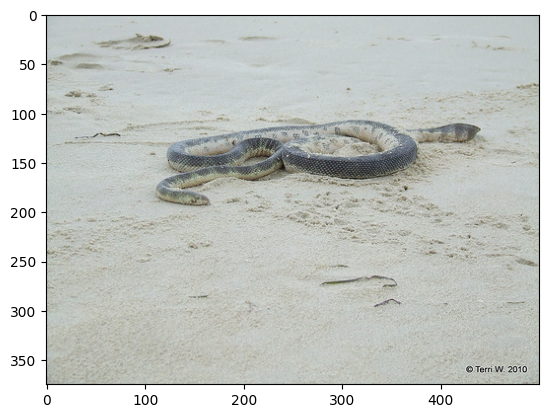

In [27]:
target_idx = utils.predict(vgg,transform,"ILSVRC2012_val_00000001.JPEG",class_names)
plt.figure()
img = Image.open("ILSVRC2012_val_00000001.JPEG").convert("RGB")
plt.imshow(img)

In [47]:
def fgsm(image, model, loss_fn,label=None,targeted = False):
    #Fast Gradient sign methord to generate adversarial images
    input_tensor = transform(image)
    input_img = input_tensor.unsqueeze(0)
    if torch.cuda.is_available():
        input_img = input_img.to('cuda')
    input_img.requires_grad_(True)

    if label is None:
        _,label = torch.max(model(input_img),1)
    print(label)

    loss = loss_fn(model(input_img),label)
    if targeted:
        loss = -loss
    grad = torch.autograd.grad(loss, input_img)[0]
    signed_grad = torch.sign(grad) 
    return signed_grad.cpu()

In [56]:
def generate_perturbation(image,model,loss_fn,target  = None):
    first_parameter = next(vgg.parameters())
    device = first_parameter.device

    if target:
        target = torch.tensor([target],device=device)
        perturbations = fgsm(img,vgg,loss_fn,label=target,targeted=True)
        perturbation_tensor = perturbations[0]
    utils.show_img(perturbation_tensor)
    return perturbation_tensor

In [57]:
loss_fn = nn.CrossEntropyLoss()

tensor([30], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


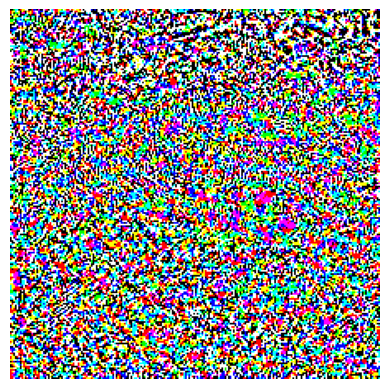

In [54]:
perturbation_tensor = generate_perturbations(img,vgg,loss_fn,target=30)

Predicted class: African rock python
Probability: 0.4571


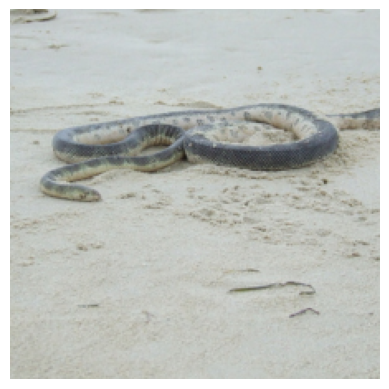

Predicted class: sidewinder
Probability: 0.3889


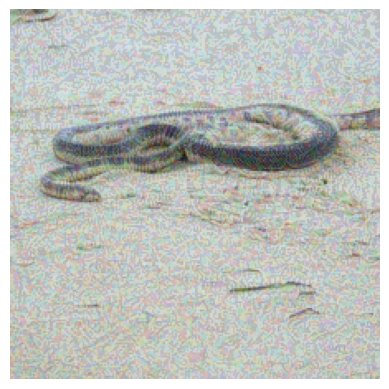

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013725489..0.954902].


Predicted class: jigsaw puzzle
Probability: 0.2633


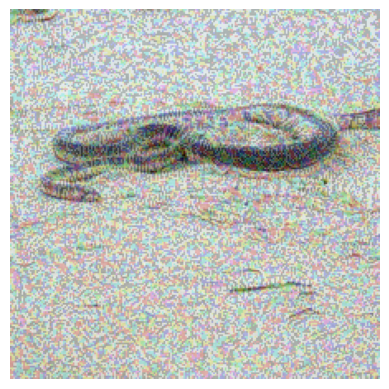

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4137255..1.354902].


Predicted class: poncho
Probability: 0.4238


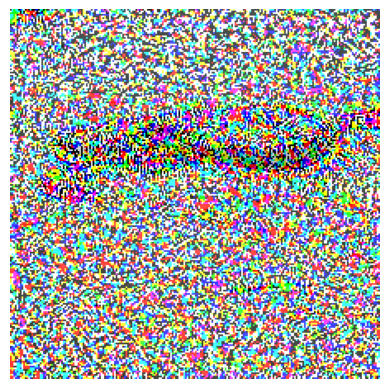

In [58]:
epsilons = [0.001,0.05,0.1,0.5]
for eps in epsilons:
    adv_x = pretransform(img)+eps*perturbations[0]
    predict(vgg,transform,normalize_transform(adv_x),True)
    utils.show_img(adv_x)